# Identify Questioning Tone by Extracting Prosodic Features

**Overview**

This notebook has 4 main parts:

1. Loading and processing the dataset (still to be determined)
2. Extracting features
3. Training neural network or other machine learning models
4. Testing and performance analysis


In [55]:

import librosa
import librosa.display
import IPython.display as ipd

import numpy as np
import pandas as pd

import torch
import torchaudio
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt
import soundfile as sf

import scipy.signal as signal

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Load Dataset

In [ ]:
# Template to load dataset

'''
Example audio paths from weekly assignment 6 used for testing
'''

audio_paths = pd.read_csv("N_1000_filtered_train_data.csv")

audio_paths = audio_paths['audio_path']

print(audio_paths)



0      audio_files/audio_10500.wav
1      audio_files/audio_10425.wav
2        audio_files/audio_882.wav
3      audio_files/audio_10309.wav
4      audio_files/audio_11616.wav
                  ...             
995     audio_files/audio_2852.wav
996     audio_files/audio_7195.wav
997     audio_files/audio_5284.wav
998      audio_files/audio_464.wav
999     audio_files/audio_2768.wav
Name: audio_path, Length: 1000, dtype: object


# Extract Features


In [60]:
# Example function to extract features

def extract_audio_features(audio_path, sr=None):
    """
    Extract relevant prosodic features from an audio file.

    Parameters:
        audio_path: Path to audio file
        sr: Sample rate (default: 22050 Hz)

    Returns:
        Dictionary of features
    """
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Design a low-pass filter
    cutoff_freq = 512  # Cutoff frequency in Hz
    nyquist = sr / 2    # Nyquist frequency
    normal_cutoff = cutoff_freq / nyquist  # Normalized cutoff frequency

    # Design a Butterworth low-pass filter
    b, a = signal.butter(4, normal_cutoff, btype='low', analog=False)

    # Apply the filter
    y = signal.filtfilt(b, a, y)

    # Extract pitch (fundamental frequency) using PYIN
    f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                                fmin=librosa.note_to_hz('C2'),
                                                fmax=librosa.note_to_hz('C7'))

    # Get pitch statistics (focusing on the end of utterance)
    f0_valid = f0[~np.isnan(f0)]
    end_window = min(len(f0_valid), int(0.5 * sr))  # Last 0.5 seconds
    f0_end = f0_valid[-end_window:] if len(f0_valid) > 0 else []

    # Extract energy contour
    energy = librosa.feature.rms(y=y)[0]

    # Calculate speaking rate proxy using zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)[0]

    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    features = {
        'f0_mean': np.mean(f0_valid) if len(f0_valid) > 0 else 0,
        'f0_std': np.std(f0_valid) if len(f0_valid) > 0 else 0,
        'f0_end_slope': np.polyfit(np.arange(len(f0_end)), f0_end, 1)[0] if len(f0_end) > 0 else 0,
        'energy_mean': np.mean(energy),
        'energy_std': np.std(energy),
        'zcr_mean': np.mean(zcr),
        'mfcc_means': np.mean(mfccs, axis=1).tolist(),
        'filepath' : audio_path
    }

    return features

In [68]:
features = []

for audio_path in audio_paths[1:500]:
  features.append(extract_audio_features(audio_path=audio_path))


features_df = pd.DataFrame(features)

In [88]:
print(features_df)

         f0_mean     f0_std  f0_end_slope  energy_mean  energy_std  zcr_mean  \
0     545.996867  55.690541     -6.876172     0.006917    0.004128  0.082935   
1       0.000000   0.000000      0.000000     0.012128    0.011864  0.058681   
2     611.583890  58.230917     -0.445379     0.027040    0.010321  0.073520   
3     635.726079  75.972980     -0.058992     0.024719    0.021063  0.083496   
4       0.000000   0.000000      0.000000     0.006671    0.003341  0.080959   
..           ...        ...           ...          ...         ...       ...   
494  1225.997744  97.528142      0.922628     0.011658    0.005578  0.095897   
495   384.868525  54.509688     -4.447720     0.008136    0.004020  0.086370   
496     0.000000   0.000000      0.000000     0.002960    0.001464  0.085834   
497   541.006657  33.006966     -3.908882     0.003049    0.001722  0.062295   
498   327.512949  27.110378     -0.148873     0.029686    0.021738  0.057342   

                                       

In [94]:
features_df2 = features_df.drop(columns=['mfcc_means']).drop(columns=['filepath'])  # Drop the file path column for PCA
features_df2 = features_df2[features_df2['f0_mean'] != 0] # Filter out rows where f0_mean is zero

In [95]:
print(features_df2)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df2)  # Standardize before PCA
print(features_scaled)


         f0_mean      f0_std  f0_end_slope  energy_mean  energy_std  zcr_mean
0     545.996867   55.690541     -6.876172     0.006917    0.004128  0.082935
2     611.583890   58.230917     -0.445379     0.027040    0.010321  0.073520
3     635.726079   75.972980     -0.058992     0.024719    0.021063  0.083496
5     562.866153  342.227537     18.420045     0.007035    0.002572  0.095703
6    1201.556113   60.470805      8.388777     0.010342    0.004202  0.101693
..           ...         ...           ...          ...         ...       ...
493   304.374867    3.871052     -0.152600     0.004300    0.001917  0.086437
494  1225.997744   97.528142      0.922628     0.011658    0.005578  0.095897
495   384.868525   54.509688     -4.447720     0.008136    0.004020  0.086370
497   541.006657   33.006966     -3.908882     0.003049    0.001722  0.062295
498   327.512949   27.110378     -0.148873     0.029686    0.021738  0.057342

[455 rows x 6 columns]
[[-0.25013511 -0.42803561 -0.61771025 -0

In [96]:
pca = PCA(n_components=2)  # Reduce to 2D
features_pca = pca.fit_transform(features_scaled)

km = KMeans(n_clusters=4, random_state=23)
labels = km.fit_predict(features_pca)


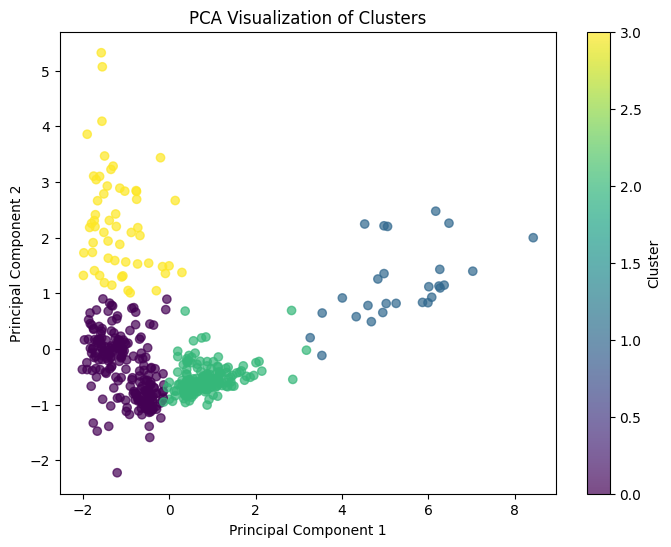

In [97]:
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Clusters')
plt.colorbar(label='Cluster')
plt.show()


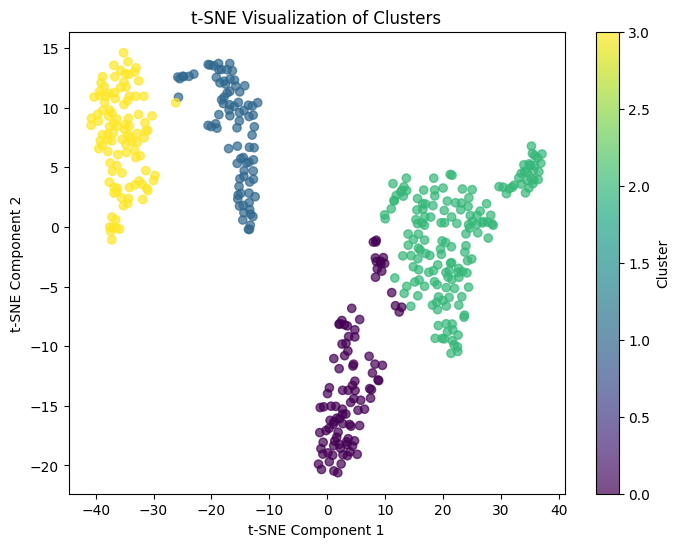

In [98]:
tsne = TSNE(n_components=2, random_state=43)
features_tsne = tsne.fit_transform(features_scaled)

labels = km.fit_predict(features_tsne)

plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Clusters')
plt.colorbar(label='Cluster')
plt.show()

# Visualize

Fundamental Frequency (f0) estimation

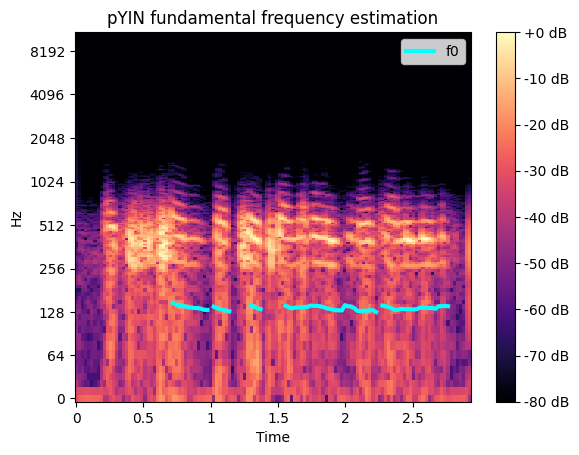

In [16]:
audio_path = audio_paths[11]

y, sr = librosa.load(audio_path)


# Design a low-pass filter
cutoff_freq = 512  # Cutoff frequency in Hz
nyquist = sr / 2    # Nyquist frequency
normal_cutoff = cutoff_freq / nyquist  # Normalized cutoff frequency

# Design a Butterworth low-pass filter
b, a = signal.butter(4, normal_cutoff, btype='low', analog=False)

# Apply the filter
y = signal.filtfilt(b, a, y)


f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                            fmin=librosa.note_to_hz('C2'),
                                            fmax=librosa.note_to_hz('C7'))



times = librosa.times_like(f0, sr=sr)

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

ipd.Audio(y, rate=sr)